In [1]:
!pip install pmdarima

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import statsmodels.api as sm
import warnings

In [3]:
from math import sqrt
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [4]:
warnings.filterwarnings("ignore")

In [5]:
df = pd.read_csv('../../data/sensor1.csv')

In [6]:
df = df.dropna()

In [7]:
units_dict = {}

for col in df.columns[1:]:
    values = []
    units = set()
    for val in df[col]:
        value, unit = val.split()
        values.append(value)
        units.add(unit)
    new_col_name = f"{col} ({units.pop()})"
    df.rename(columns={col: new_col_name}, inplace=True)
    df[new_col_name] = pd.to_numeric(values)
    units_dict[col] = units

In [8]:
df['Time'] = pd.to_datetime(df['Time'])

In [9]:
df.index = df['Time']
df.drop(columns=['Time'], inplace=True)

In [10]:
df = df.sort_index()

In [11]:
humidity = df["Humidity (%H)"]

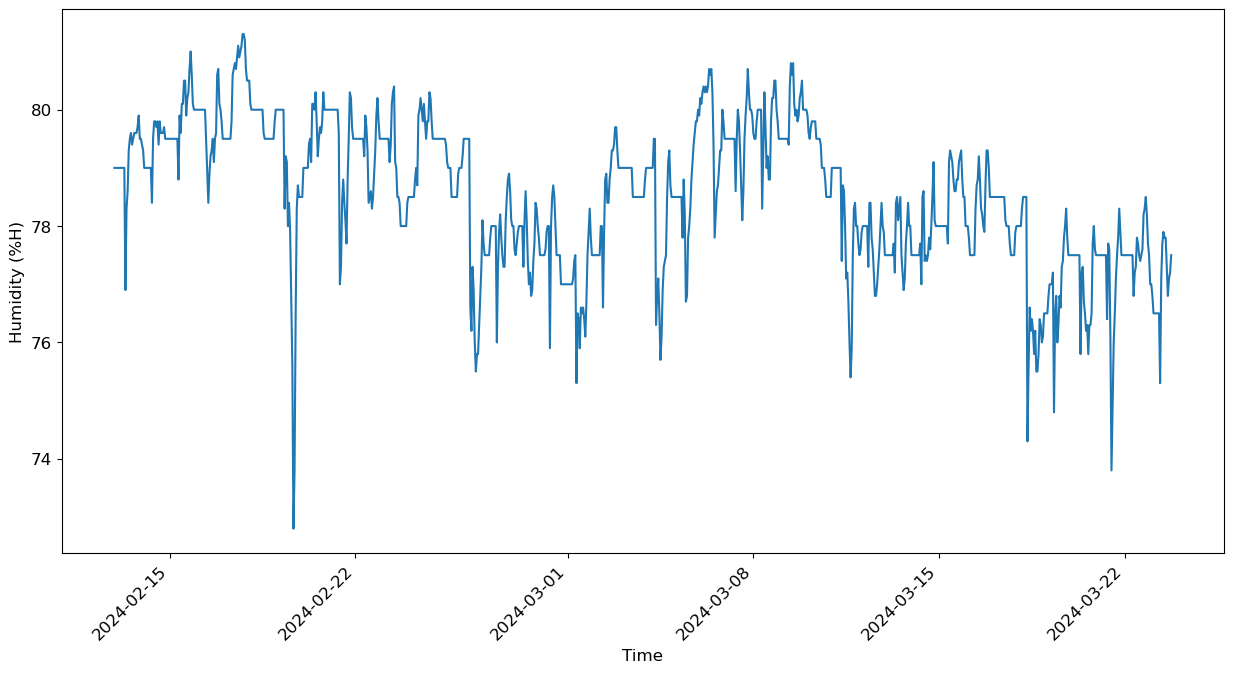

In [12]:
humidity.plot(y='Humidity (%H)', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Humidity (%H)', fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [13]:
z_scores = np.abs((humidity.values - humidity.values.mean()) / humidity.values.std())
threshold = 3
humidity = pd.DataFrame(humidity[z_scores < threshold])

Create training and testing datasets

In [14]:
train_size = int(0.8 * len(df))

In [15]:
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

In [16]:
train_start_dt = train_df.index[0]
test_start_dt = test_df.index[0]

In [17]:
train_start_dt, test_start_dt

(Timestamp('2024-02-12 22:00:00'), Timestamp('2024-03-15 20:00:00'))

In [18]:
df

CO2 (ppm)  Humidity (%H)  PM10 (μg/m³)  PM2.5 (μg/m³)  \
Time                                                                         
2024-02-12 22:00:00        456           79.0          5.60           5.60   
2024-02-12 23:00:00        456           79.0          5.25           5.13   
2024-02-13 00:00:00        456           79.0          6.00           5.89   
2024-02-13 01:00:00        450           79.0          6.44           6.33   
2024-02-13 02:00:00        447           79.0          6.25           5.88   
...                        ...            ...           ...            ...   
2024-03-23 14:00:00        475           77.3         23.30          22.20   
2024-03-23 15:00:00        481           76.8         22.30          21.70   
2024-03-23 16:00:00        487           77.1         23.70          23.00   
2024-03-23 17:00:00        499           77.2         24.80          22.70   
2024-03-23 18:00:00        505           77.5         28.00          26.00   

                     Temperature (°C)  TVOC (ppm)  
Time                                               
2024-02-12 22:00:00              24.0       0.642  
2024-02-12 23:00:00              24.1       0.711  
2024-02-13 00:00:00              24.2       0.744  
2024-02-13 01:00:00              24.2       0.759  
2024-02-13 02:00:00              24.3       0.775  
...                               ...         ...  
2024-03-23 14:00:00              23.2       0.333  
2024-03-23 15:00:00              23.2       0.308  
2024-03-23 16:00:00              23.2       0.387  
2024-03-23 17:00:00              23.1       0.343  
2024-03-23 18:00:00              23.1       0.260  

[955 rows x 6 columns]

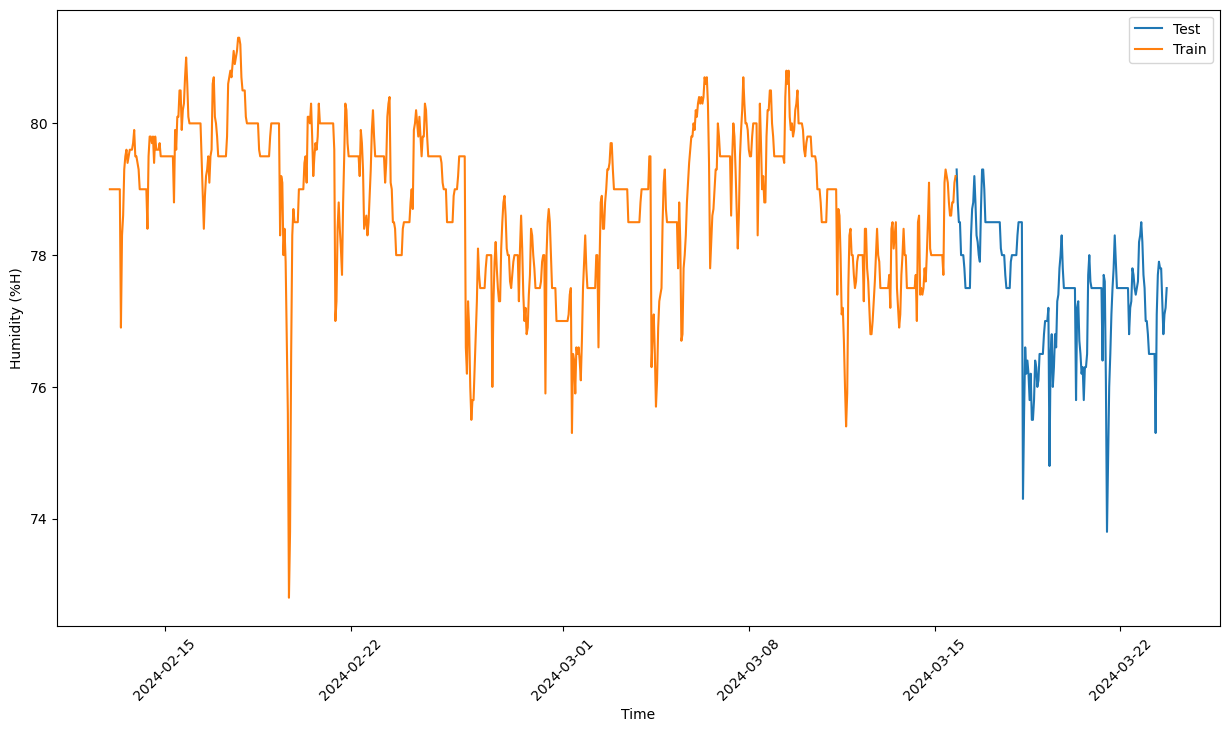

In [19]:
test_humidity = df[df.index >= test_start_dt]["Humidity (%H)"]
train_humidity = df[(df.index < test_start_dt) & (df.index >= train_start_dt)]["Humidity (%H)"]

plt.figure(figsize=(15, 8))
plt.plot(test_humidity.index, test_humidity.values, label='Test')

plt.plot(train_humidity.index, train_humidity.values, label='Train')

plt.xlabel('Time')
plt.ylabel('Humidity (%H)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

Data preparation

In [20]:
train_humidity_reshaped = train_humidity.values.reshape(-1, 1)
test_humidity_reshaped = test_humidity.values.reshape(-1, 1)

In [21]:
print("Training data shape: ", train_humidity_reshaped.shape)
print("Test data shape: ", test_humidity_reshaped.shape)

Training data shape:  (764, 1)
Test data shape:  (191, 1)


In [22]:
scaler = MinMaxScaler()
train_humidity_scaled = scaler.fit_transform(train_humidity_reshaped)
train_humidity_scaled = pd.DataFrame(train_humidity_scaled.flatten(), index=train_humidity.index, columns=["Humidity (%H)"])
train_humidity_scaled.head(10)

Humidity (%H)
Time                              
2024-02-12 22:00:00       0.729412
2024-02-12 23:00:00       0.729412
2024-02-13 00:00:00       0.729412
2024-02-13 01:00:00       0.729412
2024-02-13 02:00:00       0.729412
2024-02-13 03:00:00       0.729412
2024-02-13 04:00:00       0.729412
2024-02-13 05:00:00       0.729412
2024-02-13 06:00:00       0.729412
2024-02-13 07:00:00       0.729412

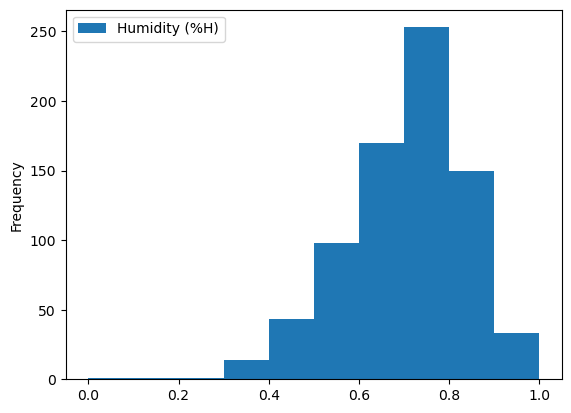

In [23]:
train_humidity_scaled.plot.hist(bins=10)
plt.show()

In [24]:
test_humidity_scaled = scaler.fit_transform(test_humidity_reshaped)
test_humidity_scaled = pd.DataFrame(test_humidity_scaled.flatten(), index=test_humidity.index, columns=["Humidity (%H)"])
test_humidity_scaled.head(10)

Humidity (%H)
Time                              
2024-03-15 20:00:00       1.000000
2024-03-15 21:00:00       0.909091
2024-03-15 22:00:00       0.854545
2024-03-15 23:00:00       0.854545
2024-03-16 00:00:00       0.763636
2024-03-16 01:00:00       0.763636
2024-03-16 02:00:00       0.763636
2024-03-16 03:00:00       0.727273
2024-03-16 04:00:00       0.672727
2024-03-16 05:00:00       0.672727

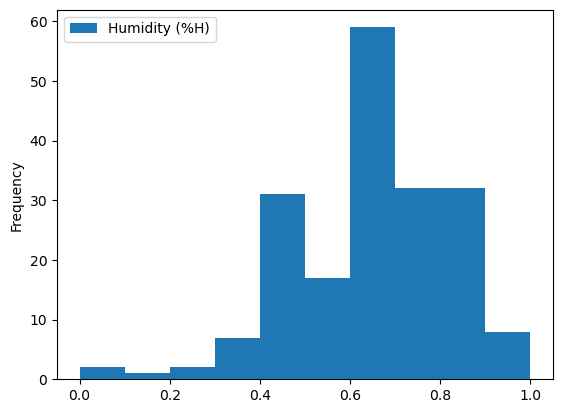

In [25]:
test_humidity_scaled.plot.hist(bins=10)
plt.show()

In [26]:
HORIZON_HUMIDITY = 1

In [27]:
stepwise_fit_humidity = auto_arima(train_humidity_scaled, trace=True, suppress_warnings=True)
stepwise_fit_humidity.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2214.389, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2169.904, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2168.301, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2168.481, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2171.904, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2215.390, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2188.877, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2205.459, Time=0.24 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-2211.683, Time=0.33 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-2194.034, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2213.571, Time=0.28 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-2212.132, Time=0.47 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-2217.365, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-2190.877, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  764
Model:               SARIMAX(1, 1, 2)   Log Likelihood                1112.682
Date:                Sat, 23 Mar 2024   AIC                          -2217.365
Time:                        18:19:14   BIC                          -2198.816
Sample:                             0   HQIC                         -2210.223
                                - 764                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7526      0.043     17.392      0.000       0.668       0.837
ma.L1         -0.7721      0.047    -16.562      0.000      -0.863      -0.681
ma.L2         -0.1625      0.029     -5.674      0.000      -0.219      -0.106
sigma2         0.0032   6.58e-05     48.101      0.000       0.003       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              3674.92
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                            -1.55
Prob(H) (two-sided):                  0.07   Kurtosis:                        13.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
order_humidity = (1,1,3)

In [29]:
model_humidity =  ARIMA(endog=train_humidity_scaled, order=order_humidity)
result_humidity = model_humidity.fit()

print(result_humidity.summary())

                               SARIMAX Results                                
Dep. Variable:          Humidity (%H)   No. Observations:                  764
Model:                 ARIMA(1, 1, 3)   Log Likelihood                1113.676
Date:                Sat, 23 Mar 2024   AIC                          -2217.351
Time:                        18:19:14   BIC                          -2194.165
Sample:                             0   HQIC                         -2208.424
                                - 764                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8126      0.046     17.518      0.000       0.722       0.904
ma.L1         -0.8390      0.050    -16.771      0.000      -0.937      -0.741
ma.L2         -0.1867      0.035     -5.398      0.0

Walk-forward validation

Create a test data point for each HORIZON.<br>
Shift the data horizontally according to its horizon point.

In [30]:
test_humidity_shifted = test_humidity_scaled.copy()

for t in range(1, HORIZON_HUMIDITY):
    test_humidity_shifted["Humidity (%H)+" + str(t)] = test_humidity_shifted["Humidity (%H)"].shift(-t, freq='H')
    
test_humidity_shifted = test_humidity_shifted.dropna(how='any')
test_humidity_shifted.head()

Humidity (%H)
Time                              
2024-03-15 20:00:00       1.000000
2024-03-15 21:00:00       0.909091
2024-03-15 22:00:00       0.854545
2024-03-15 23:00:00       0.854545
2024-03-16 00:00:00       0.763636

Make predictions on the test data using a sliding window approach in a loop the size of the test data length.

In [31]:
stepwise_fit_humidity_test = auto_arima(test_humidity_scaled, trace=True, suppress_warnings=True)
stepwise_fit_humidity_test.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-314.178, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-302.416, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-303.230, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-304.947, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-304.367, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-315.773, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-311.254, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-317.722, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-315.759, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-308.582, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-318.970, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-306.874, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-305.170, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-317.035, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  191
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 162.485
Date:                Sat, 23 Mar 2024   AIC                           -318.970
Time:                        18:19:15   BIC                           -309.229
Sample:                    03-15-2024   HQIC                          -315.024
                         - 03-23-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7153      0.067     10.740      0.000       0.585       0.846
ma.L1         -0.9438      0.038    -24.962      0.000      -1.018      -0.870
sigma2         0.0105      0.000     28.919      0.000       0.010       0.011
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              2463.17
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                            -2.79
Prob(H) (two-sided):                  0.67   Kurtosis:                        19.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
test_humidity_shifted

Humidity (%H)
Time                              
2024-03-15 20:00:00       1.000000
2024-03-15 21:00:00       0.909091
2024-03-15 22:00:00       0.854545
2024-03-15 23:00:00       0.854545
2024-03-16 00:00:00       0.763636
...                            ...
2024-03-23 14:00:00       0.636364
2024-03-23 15:00:00       0.545455
2024-03-23 16:00:00       0.600000
2024-03-23 17:00:00       0.618182
2024-03-23 18:00:00       0.672727

[191 rows x 1 columns]

In [33]:
%%time
training_window = 168

train_ts_humidity = train_humidity_scaled["Humidity (%H)"]
test_ts_humidity = test_humidity_shifted

history_humidity = [x for x in train_ts_humidity]
history_humidity = history_humidity[(-training_window):]

predictions_humidity = list()

# order = (0,1,0)

for t in range(test_ts_humidity.shape[0]):
    model_humidity = ARIMA(endog=history_humidity, order=order_humidity)
    model_fit_humidity = model_humidity.fit()
    yhat = model_fit_humidity.forecast(steps = HORIZON_HUMIDITY)
    predictions_humidity.append(yhat)
    obs = list(test_ts_humidity.iloc[t])
    # move the training window
    history_humidity.append(obs[0])
    history_humidity.pop(0)
    print(test_ts_humidity.index[t])
    print(t+1, ': predicted =', yhat, 'expected =', obs)

2024-03-15 20:00:00
1 : predicted = [0.74560997] expected = [1.0]
2024-03-15 21:00:00
2 : predicted = [0.97115071] expected = [0.9090909090909083]
2024-03-15 22:00:00
3 : predicted = [0.87629748] expected = [0.8545454545454554]
2024-03-15 23:00:00
4 : predicted = [0.85419367] expected = [0.8545454545454554]
2024-03-16 00:00:00
5 : predicted = [0.84824639] expected = [0.7636363636363637]
2024-03-16 01:00:00
6 : predicted = [0.76088643] expected = [0.7636363636363637]
2024-03-16 02:00:00
7 : predicted = [0.7667843] expected = [0.7636363636363637]
2024-03-16 03:00:00
8 : predicted = [0.75823175] expected = [0.7272727272727266]
2024-03-16 04:00:00
9 : predicted = [0.73379166] expected = [0.6727272727272737]
2024-03-16 05:00:00
10 : predicted = [0.68670597] expected = [0.6727272727272737]
2024-03-16 06:00:00
11 : predicted = [0.67726138] expected = [0.6727272727272737]
2024-03-16 07:00:00
12 : predicted = [0.67313768] expected = [0.6727272727272737]
2024-03-16 08:00:00
13 : predicted = [0.6

Compare the prediction against the actual Humidity.

In [34]:
eval_df_humidity = pd.DataFrame(predictions_humidity, columns=['t+'+str(t) for t in range(1, HORIZON_HUMIDITY+1)])
eval_df_humidity['Time'] = test_humidity_scaled.index[0:len(test_humidity_scaled.index)-HORIZON_HUMIDITY+1]
eval_df_humidity = pd.melt(eval_df_humidity, id_vars='Time', value_name='Prediction', var_name='H')
eval_df_humidity['Actual'] = np.array(np.transpose(test_ts_humidity)).ravel()
eval_df_humidity[['Prediction', 'Actual']] = scaler.inverse_transform(eval_df_humidity[['Prediction', 'Actual']])
eval_df_humidity.head()

Time    H  Prediction  Actual
0 2024-03-15 20:00:00  t+1   77.900855    79.3
1 2024-03-15 21:00:00  t+1   79.141329    78.8
2 2024-03-15 22:00:00  t+1   78.619636    78.5
3 2024-03-15 23:00:00  t+1   78.498065    78.5
4 2024-03-16 00:00:00  t+1   78.465355    78.0

Check the model accuracy by testing its mean absolute percentage error (MAPE) over all the predictions.

In [35]:
if (HORIZON_HUMIDITY > 1):
    eval_df_humidity['APE'] = (eval_df_humidity['Prediction'] - eval_df_humidity['Actual']).abs()
    print(eval_df_humidity.groupby('H')['APE'].mean())

In [36]:
# Mean absolute percentage error
def mape(predictions, actuals):
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    return (np.absolute(predictions - actuals) / actuals).mean()

In [37]:
print('Multi-step forecast MAPE: ', mape(eval_df_humidity['Prediction'], eval_df_humidity['Actual'])*100, '%')

Multi-step forecast MAPE:  0.423081856189916 %


In [38]:
rmse_humidity = sqrt(mean_squared_error(eval_df_humidity['Prediction'], eval_df_humidity['Actual']))
rmse_humidity

0.5887800990997183

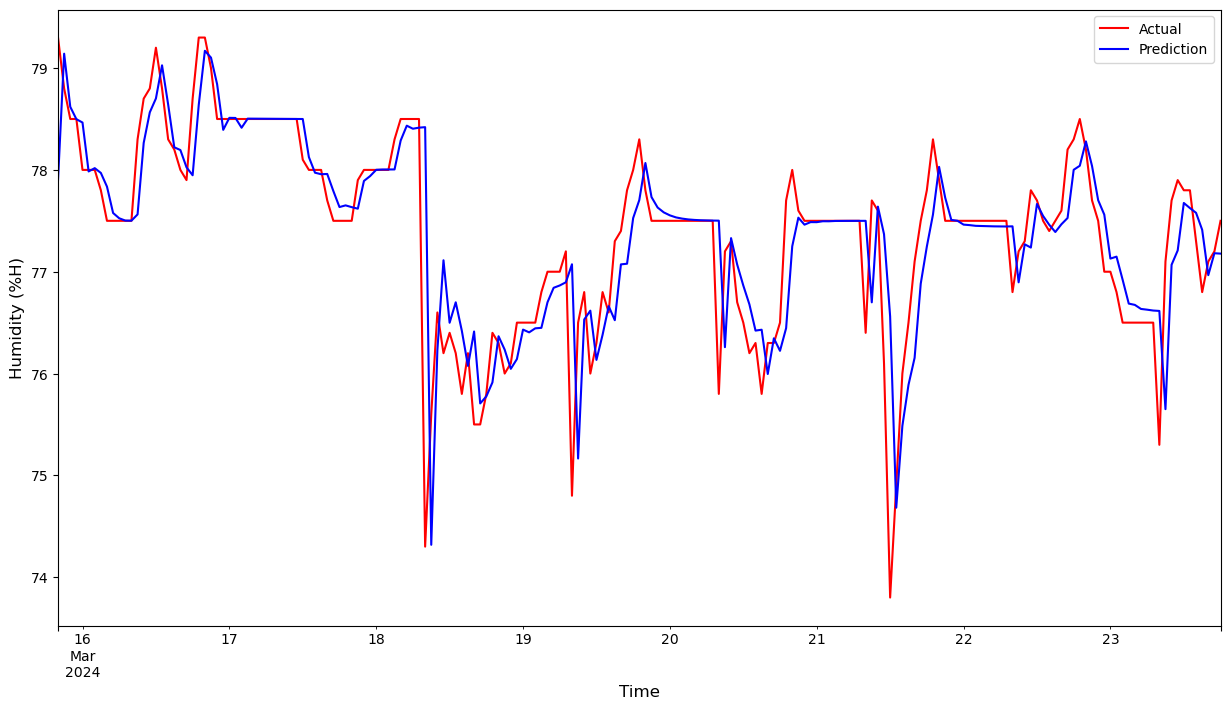

In [39]:
if HORIZON_HUMIDITY == 1:
    eval_df_humidity.plot(x='Time', y=['Actual', 'Prediction'], style=['r', 'b'], figsize=(15, 8))
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Humidity (%H)', fontsize=12)
    plt.legend(['Actual', 'Prediction'], loc='best')
    plt.show()
else:
    plot_df_humidity = eval_df_humidity[(eval_df_humidity.H == 't+1')][['Time', 'Actual']]
    for t in range(1, HORIZON_HUMIDITY + 1):
        plot_df_humidity['t+' + str(t)] = eval_df_humidity[(eval_df_humidity.H == 't+' + str(t))]['Prediction'].values

    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111)
    ax.plot(plot_df_humidity['Time'], plot_df_humidity['Actual'], color='red', linewidth=4.0, label='Actual')
    for t in range(1, HORIZON_HUMIDITY + 1):
        x = plot_df_humidity['Time'][(t - 1):]
        y = plot_df_humidity['t+' + str(t)][0:len(x)]
        ax.plot(x, y, color='blue', linewidth=4 * math.pow(.9, t), alpha=math.pow(0.8, t),
                label='Prediction t+' + str(t))

    ax.legend(loc='best')
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Humidity (%H)', fontsize=12)
    plt.show()

In [40]:
next_hour = pd.date_range(start=df.index[-1], periods=2, freq='H')[-1]

In [41]:
pred_humidity = model_fit_humidity.predict(start=len(df), end=len(df), typ="levels")[0]
pred_humidity_nonscaled = round(scaler.inverse_transform(np.array(pred_humidity).reshape(-1, 1))[0][0], 1)
print(f"{next_hour} {pred_humidity_nonscaled}")

2024-03-23 19:00:00 77.2


In [42]:
with open('arima_humidity.pickle', 'wb') as f:
    pickle.dump(model_fit_humidity, f)